-1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
-1.0 * X(0) + -1.0 * X(1) + -1.0 * X(2) + -1.0 * X(3)
(2+0j) * Y(0) + (2+0j) * Y(1) + (2+0j) * Y(2) + (2+0j) * Y(3)
第 1 步: E = -0.00000000 Ha, β_1 = -0.000000
第 2 步: E = -0.04950557 Ha, β_2 = 0.158935
第 3 步: E = -0.18992419 Ha, β_3 = 0.311377
第 4 步: E = -0.44637178 Ha, β_4 = 0.450068
第 5 步: E = -0.82005421 Ha, β_5 = 0.566547
第 6 步: E = -1.28419406 Ha, β_6 = 0.651691
第 7 步: E = -1.78781197 Ha, β_7 = 0.697468
第 8 步: E = -2.26922073 Ha, β_8 = 0.699434
第 9 步: E = -2.67484976 Ha, β_9 = 0.658738
第 10 步: E = -2.97422071 Ha, β_10 = 0.582260
第 11 步: E = -3.16416405 Ha, β_11 = 0.480642
第 12 步: E = -3.26281294 Ha, β_12 = 0.365356
第 13 步: E = -3.29916077 Ha, β_13 = 0.246396
第 14 步: E = -3.30362968 Ha, β_14 = 0.131316
第 15 步: E = -3.30194868 Ha, β_15 = 0.025359
第 16 步: E = -3.31219772 Ha, β_16 = -0.067964
第 17 步: E = -3.34407684 Ha, β_17 = -0.146303
第 18 步: E = -3.39960412 Ha, β_18 = -0.208143
第 19 步: E = -3.47475221 Ha, β_19 = -0.252698
第 20 步:

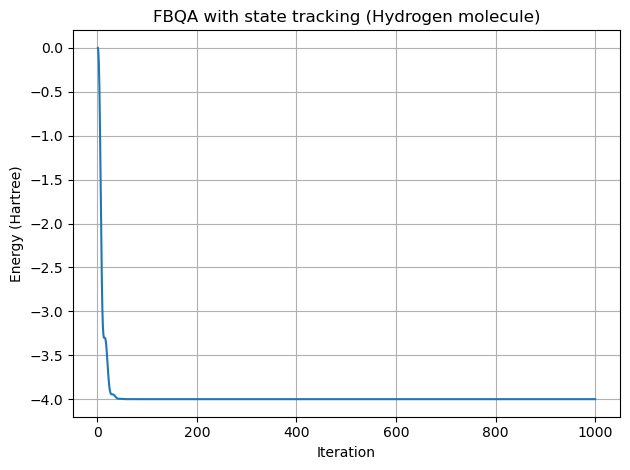

In [8]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

qubits = 4
dev = qml.device("default.qubit", wires=qubits)

def build_cost_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliZ(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

def build_driver_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

cost_h = build_cost_h(n_qubits)
print(cost_h)

driver_h = build_driver_h(n_qubits)
print(driver_h)

def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, cost_h)
print(comm_h)


@qml.qnode(dev)
def plus_state():
    for w in range(qubits):
        qml.Hadamard(w)
    return qml.state()

# 6. 单步 FALQON 演化矩阵
def single_falqon_unitary(beta_k, delta_t, cost_h, driver_h):
    U_cost = qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    U_driver = qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)
    return qml.matrix(U_driver @ U_cost, wire_order=range(qubits))

# 7. 测量期望值 ⟨ψ|H|ψ⟩
def measure_expectation(state, H):
    H_mat = qml.matrix(H, wire_order=range(qubits))
    return np.real(np.vdot(state, H_mat @ state))

# 8. 主流程：状态保留式 FALQON
def run_fbqa_state_tracking(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    state = plus_state()

    for i in range(n_steps):
        # 计算 feedback beta
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -delta_t * exp_comm
        beta_list.append(next_beta)

        # 应用下一步 unitary
        U_k = single_falqon_unitary(next_beta, delta_t, H, driver_h)
        state = U_k @ state

        # 计算能量
        energy = measure_expectation(state, H)
        energy_list.append(energy)

        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

# 9. 设置参数并运行
n_steps = 1000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(cost_h, driver_h, comm_h, n_steps, beta_1, delta_t)

# 10. 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA with state tracking (Hydrogen molecule)")
plt.grid(True)
plt.tight_layout()
plt.show()